In [2]:
# import python libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
from scipy import stats

In [3]:
# set plotting settings
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.size'] = 18

In [4]:
# set seaborn style 
sns.set()
sns.set_style("whitegrid")

In [5]:
# import spatial libraries
import geopandas as gpd
from shapely.geometry import Point,Polygon

### SPATIAL JOIN

In [46]:
# load SRS open dataset
df = pd.read_csv("open_data.csv") 
df.head()

,latitude,longitude,ppe,osm_id,highway,"""quality""","""passengers""","""updated_at"""
0,42.823688,12.399041,0.249243,223578221,trunk,NaN,NaN,2018-03-20 13:11:32.790807
1,42.823504,12.399083,0.289182,223578221,trunk,NaN,NaN,2018-03-20 13:11:32.790807
2,42.825936,12.398878,0.253153,223578221,trunk,NaN,NaN,2018-03-20 13:11:32.790807
3,42.825747,12.398865,0.262400,223578221,trunk,NaN,NaN,2018-03-20 13:11:32.790807
4,42.825559,12.398853,0.543022,223578221,trunk,NaN,NaN,2018-03-20 13:11:32.790807


In [6]:
# rename columns
df.columns = ["latitude", "longitude", "ppe", "osm_id", "road", "quality", "passengers", "timestamp"] 
# drop quality and passenger columns (generally empty field)
df = df.drop(columns=["quality", "passengers"])

df.head() 

,latitude,longitude,ppe,osm_id,road,timestamp
0,42.823688,12.399041,0.249243,223578221,trunk,2018-03-20 13:11:32.790807
1,42.823504,12.399083,0.289182,223578221,trunk,2018-03-20 13:11:32.790807
2,42.825936,12.398878,0.253153,223578221,trunk,2018-03-20 13:11:32.790807
3,42.825747,12.398865,0.262400,223578221,trunk,2018-03-20 13:11:32.790807
4,42.825559,12.398853,0.543022,223578221,trunk,2018-03-20 13:11:32.790807


In [7]:
# add geometry
geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])] 

# create geodataframe (for plotting and spatial join)
geo_df = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=geometry) 

In [8]:
# get countries borders
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.to_crs("EPSG:4326")
#italy =  world[world.name == "Italy"]

In [9]:
# add country name to dataframe points
geo_countries = gpd.sjoin(geo_df, world, how="left")
geo_countries = geo_countries.drop(columns=["index_right","pop_est", "continent","iso_a3","gdp_md_est"])
geo_countries = geo_countries.rename(columns={"name":"country"})
geo_countries.head()

,latitude,longitude,ppe,osm_id,road,timestamp,geometry,country
0,42.823688,12.399041,0.249243,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39904 42.82369),Italy
1,42.823504,12.399083,0.289182,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39908 42.82350),Italy
2,42.825936,12.398878,0.253153,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39888 42.82594),Italy
3,42.825747,12.398865,0.262400,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39886 42.82575),Italy
4,42.825559,12.398853,0.543022,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39885 42.82556),Italy


In [10]:
# calculate number of mapped points per country
geo_countries.groupby(["country"]).size()

country
Austria                         145
Belgium                      123837
Denmark                       35938
France                          104
Greece                        15510
Hungary                      142523
Italy                       2716890
Moldova                         410
Portugal                       1124
Romania                      271571
Slovakia                       2672
Switzerland                     964
United Kingdom               190657
United States of America       9515
dtype: int64

In [11]:
# calculate percentage of mapped points per country
round(geo_countries.groupby(["country"]).size()/len(geo_countries)*100,2)

country
Austria                      0.00
Belgium                      3.43
Denmark                      0.99
France                       0.00
Greece                       0.43
Hungary                      3.94
Italy                       75.14
Moldova                      0.01
Portugal                     0.03
Romania                      7.51
Slovakia                     0.07
Switzerland                  0.03
United Kingdom               5.27
United States of America     0.26
dtype: float64

In [12]:
#import geoJson Italy cities
italy_cities = gpd.read_file('geojson_italy_cities/italy_all_cities.geojson') 
italy_cities = italy_cities.drop(columns = ["NOME_TED","SHAPE_Leng","SHAPE_Area"])
italy_cities = italy_cities.rename(columns={"NOME_COM": "NAME_COM", "PRO_COM": "COD_COM"})
italy_cities.head()

,COD_REG,COD_PRO,COD_COM,NAME_COM,geometry
0,1,4,4033,Brossasco,"POLYGON ((7.28702 44.61072, 7.30248 44.60028, ..."
1,1,4,4034,Busca,"POLYGON ((7.51064 44.55156, 7.51302 44.55040, ..."
2,1,4,4035,Camerana,"POLYGON ((8.16128 44.45065, 8.16485 44.44369, ..."
3,1,4,4036,Camo,"POLYGON ((8.20767 44.69655, 8.20410 44.69307, ..."
4,1,4,4037,Canale,"POLYGON ((7.99000 44.82530, 7.99476 44.81834, ..."


In [13]:
# import provinces names and codes (ISTAT)
provinces = pd.read_csv("province_names.csv", header = None)
provinces.columns = ["COD_PRO", "NAME_PRO"]
provinces.head()

,COD_PRO,NAME_PRO
0,1,Torino
1,2,Vercelli
2,3,Novara
3,4,Cuneo
4,5,Asti


In [14]:
# import region names and codes (ISTAT)
regions = pd.read_csv("region_names.csv", header = None)
regions.columns = ["COD_REG", "NAME_REG"]
regions.head()

,COD_REG,NAME_REG
0,1,Piemonte
1,2,Valle d'Aosta
2,3,Lombardia
3,4,Trentino-Alto Adige
4,5,Veneto


In [15]:
# add region and province names to geojson cities file
italy_cities = pd.merge(italy_cities, provinces,on="COD_PRO")
italy_cities = pd.merge(italy_cities, regions,on="COD_REG")
italy_cities.head()

,COD_REG,COD_PRO,COD_COM,NAME_COM,geometry,NAME_PRO,NAME_REG
0,1,4,4033,Brossasco,"POLYGON ((7.28702 44.61072, 7.30248 44.60028, ...",Cuneo,Piemonte
1,1,4,4034,Busca,"POLYGON ((7.51064 44.55156, 7.51302 44.55040, ...",Cuneo,Piemonte
2,1,4,4035,Camerana,"POLYGON ((8.16128 44.45065, 8.16485 44.44369, ...",Cuneo,Piemonte
3,1,4,4036,Camo,"POLYGON ((8.20767 44.69655, 8.20410 44.69307, ...",Cuneo,Piemonte
4,1,4,4037,Canale,"POLYGON ((7.99000 44.82530, 7.99476 44.81834, ...",Cuneo,Piemonte


In [16]:
# spatial left join to add city, province, region names to dataset points 
geo_df_cities = geo_df.sjoin(italy_cities, how="left")
geo_df_cities.head()

,latitude,longitude,ppe,osm_id,road,timestamp,geometry,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG
0,42.823688,12.399041,0.249243,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39904 42.82369),5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
1,42.823504,12.399083,0.289182,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39908 42.82350),5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
2,42.825936,12.398878,0.253153,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39888 42.82594),5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
3,42.825747,12.398865,0.262400,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39886 42.82575),5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
4,42.825559,12.398853,0.543022,223578221,trunk,2018-03-20 13:11:32.790807,POINT (12.39885 42.82556),5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria


In [17]:
# extract points mapped to Italian cities
geo_df_cities = geo_df_cities[geo_df_cities["NAME_COM"].notna()]

In [18]:
# save updated dataframe
geo_df_cities.drop('geometry',axis=1).to_csv(r'Italy_ppe.csv') 

In [19]:
# drop geometry data
df = geo_df_cities.drop('geometry',axis=1)

### STATISTICAL MODELLING


In [55]:
# load dataset

df = pd.read_csv("Italy_ppe.csv") 
df = df.drop(columns="Unnamed: 0")
df.head()

,latitude,longitude,ppe,osm_id,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG
0,42.823688,12.399041,0.249243,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
1,42.823504,12.399083,0.289182,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
2,42.825936,12.398878,0.253153,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
3,42.825747,12.398865,0.262400,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria
4,42.825559,12.398853,0.543022,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria


In [56]:
# remove outliers top as in Alessandroni et al. 2014
df = df[(df["ppe"] > 0.001 ) & (df["ppe"] < 4)]  

# remove bottom 1%
df = df[df["ppe"] > df["ppe"].quantile(0.01) ] 

# calculate logarithm of ppe
df["log_ppe"] = np.log(df["ppe"])

df.head() 

,latitude,longitude,ppe,osm_id,road,timestamp,index_right,COD_REG,COD_PRO,COD_COM,NAME_COM,NAME_PRO,NAME_REG,log_ppe
0,42.823688,12.399041,0.249243,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.389328
1,42.823504,12.399083,0.289182,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.240700
2,42.825936,12.398878,0.253153,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.373763
3,42.825747,12.398865,0.262400,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-1.337885
4,42.825559,12.398853,0.543022,223578221,trunk,2018-03-20 13:11:32.790807,5800.0,10.0,54.0,54052.0,Todi,Perugia,Umbria,-0.610605


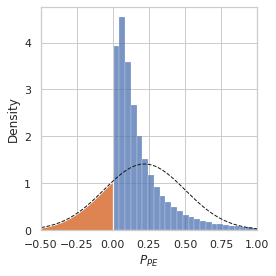

In [57]:
# plot ppe distribution and best fit normal distribution

rcParams['figure.figsize'] = [4, 4]

from scipy.stats import norm

d = df["ppe"]
# plot density distribution
sns.histplot(data = d,bins = 100, stat = "density")

# plot best fit normal distribution
mu, std = norm.fit(d)
x = np.linspace(-1, 1, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1, ls = "--")
plt.xlim([-0.5,1])
x1 = np.linspace(-1, 0, 100)
p1 = norm.pdf(x1, mu, std)
plt.fill_between(x1,p1)
plt.xlabel("$P_{PE}$")
plt.tight_layout()
#plt.savefig("fig1a_", format='svg', transparent=True)
plt.show()

In [58]:
# interval within 3 standard deviations
print(round(mu - 3*std,3), round(mu + 3*std,3))

-0.629 1.067


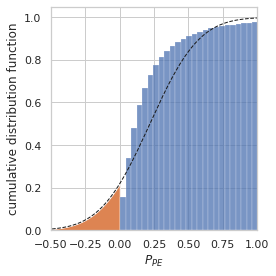

In [10]:
# plot cumulative distribution of ppe and best fit normal distribution

rcParams['figure.figsize'] = [4, 4]

from scipy.stats import norm

d = df["ppe"]
# plot cumulative distribution of ppe
sns.histplot(data = d,bins = 100, stat = "probability", cumulative = True)

# plot cumulative distribution of best fit normal distribution
mu, std = norm.fit(d)
x = np.linspace(-1, 1, 1000)
p = norm.cdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1, ls = "--")
plt.xlim([-0.5,1])
x1 = np.linspace(-1, 0, 100)
p1 = norm.cdf(x1, mu, std)
plt.ylabel("cumulative distribution function")
plt.fill_between(x1,p1)
plt.xlabel("$P_{PE}$")
plt.tight_layout()
#plt.savefig("fig1b_", format='svg', transparent=True)
plt.show()

In [60]:
# calculate mean and standard deviation of the ppe
d = df["ppe"]
mudf = d.mean()
stddf = d.std()
print(mudf, stddf)

0.21941511619355006 0.2826512602065321


In [12]:
# calculate skewness
d.skew()

4.247933784637891

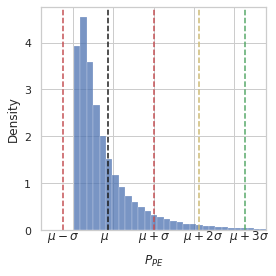

In [13]:
rcParams['figure.figsize'] = [4, 4]

from scipy.stats import norm

d = df["ppe"]
sns.histplot(data = d,bins = 100, stat = "density")

plt.axvline(x=mudf, ls = "--", color = "k")
plt.axvline(x=mudf + stddf, ls = "--" , color = "r")
plt.axvline(x=mudf + 2*stddf, ls = "--", color = "y")
plt.axvline(x=mudf + 3*stddf, ls = "--", color = "g")
plt.axvline(x=mudf - stddf, ls = "--" , color = "r")
#plt.axvline(x=mudf - 2*stddf, ls = "--", color = "b")
#plt.axvline(x=mudf - 3*stddf, ls = "--", color = "g")
plt.xlim([-0.2,1.2])
plt.xticks(color = "w")
plt.text( x = mudf-0.05, y = -0.2, s = "$\mu$")
plt.text( x = mudf - stddf -0.1, y = -0.2, s = "$\mu - \sigma$")
plt.text( x = mudf + stddf -0.1, y = -0.2, s = "$\mu + \sigma$")
plt.text( x = mudf + 2*stddf -0.1, y = -0.2, s = "$\mu + 2\sigma$")
plt.text( x = mudf + 3*stddf -0.1, y = -0.2, s = "$\mu + 3\sigma$")
plt.xlabel("$P_{PE}$")
plt.tight_layout()
#plt.savefig("fig2_", format='svg', transparent=True)
plt.show()

In [61]:
# calculate percentage of point within one standard deviation from the mean
round(len(d[(d > (mudf - stddf)) & ( d < (mudf + stddf))])/len(d)*100,1)

90.6

In [62]:
# interval within one standard deviation from the mean
print(round(mudf - stddf,3), round(mudf + stddf,3))

-0.063 0.502


In [63]:
# calculate percentage of points below the mean
round(len(d[ d < mudf ])/len(d)*100,1)

69.1

In [64]:
# calculate mean and standard deviation of the transformed ppe
d = df["log_ppe"]
muldf = d.mean()
stdldf = d.std()

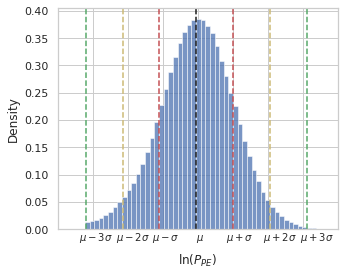

In [65]:
# plot aritmetic mean and standard deviation in the transformed domain

rcParams['figure.figsize'] = [5, 4]

from scipy.stats import norm

d = df["log_ppe"]
sns.histplot(data = d,bins = 50, stat = "density")

plt.axvline(x=muldf, ls = "--", color = "k")
plt.axvline(x=muldf + stdldf, ls = "--" , color = "r")
plt.axvline(x=muldf + 2*stdldf, ls = "--", color = "y")
plt.axvline(x=muldf + 3*stdldf, ls = "--", color = "g")
plt.axvline(x=muldf - stdldf, ls = "--" , color = "r")
plt.axvline(x=muldf - 2*stdldf, ls = "--", color = "y")
plt.axvline(x=muldf - 3*stdldf, ls = "--", color = "g")
plt.xlim([-6,2])
plt.xlabel("ln($P_{PE}$)")
plt.xticks(color = "w")

spacing = - 0.2
plt.text( x = muldf, y = -0.02, s = "$\mu$", fontsize = 10)
plt.text( x = muldf - stdldf + spacing, y = -0.02, s = "$\mu-\sigma$", fontsize = 10)
plt.text( x = muldf - 2*stdldf + spacing , y = -0.02, s = "$\mu-2\sigma$", fontsize = 10)
plt.text( x = muldf - 3*stdldf + spacing , y = -0.02, s = "$\mu-3\sigma$", fontsize = 10)
plt.text( x = muldf + stdldf + spacing , y = -0.02, s = "$\mu+\sigma$", fontsize = 10)
plt.text( x = muldf + 2*stdldf + spacing , y = -0.02, s = "$\mu+2\sigma$", fontsize = 10)
plt.text( x = muldf + 3*stdldf + spacing , y = -0.02, s = "$\mu+3\sigma$", fontsize = 10)
plt.tight_layout()
#plt.savefig("fig3a_", format='svg', transparent=True)
plt.show()

In [67]:
# calculate n of points within 1,2,3 standard deviation in the transformed domain

round(len(d[(d > (muldf - 1*stdldf)) & ( d < (muldf + 1*stdldf))])/len(d)*100,1)

68.8

In [68]:
round(len(d[(d > (muldf - 2*stdldf)) & ( d < (muldf + 2*stdldf))])/len(d)*100,1)

95.0

In [69]:
round(len(d[(d > (muldf - 3*stdldf)) & ( d < (muldf + 3*stdldf))])/len(d)*100,1)

99.9

In [71]:
# calculate percentage of points below the mean

round(len(d[ d < muldf ])/len(d)*100,1)

49.2

In [72]:
# calculate the skewness

d.skew()

-0.11313469758788289

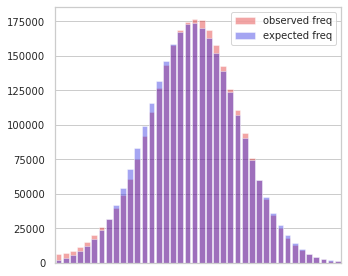

In [37]:
d = df["log_ppe"]

# calculate observed frequency
histo, bin_edges = np.histogram(d, bins=40)
number_of_bins = len(bin_edges) - 1
observed_values = histo

# calculate expected frequency
np.set_printoptions(suppress=True)
mu, std = norm.fit(d)
cdf = norm.cdf(bin_edges,mu, std)
expected_values = len(d) * np.diff(cdf)

# plot
sns.barplot(x = bin_edges[1:],y = observed_values, color = "red", alpha = 0.4,  label = "observed freq")
sns.barplot(x = bin_edges[1:],y = expected_values, color = "blue", alpha = 0.4,  label = "expected freq")
plt.legend(fontsize = 10)

#plt.xlim([-5,1])
plt.xticks([])
plt.yticks(fontsize = 10)
plt.tight_layout()
#plt.savefig("fig4a_", format='svg', transparent=True)
plt.show()

In [45]:
# compare a sample of the tranform data to the best fit normal distribution
import random

# size of the sample
s = 1000
# normal distribution parameters
mu, std = norm.fit(df["log_ppe"])
# extract a random sample
sampled = random.sample(list(df["log_ppe"]),s)
# apply the Kolmogorov-Smirnov test
c,pv = stats.kstest(stats.norm.rvs(loc = mu, scale = std, size=s), sampled)
# p-value
pv

0.9542189106778983

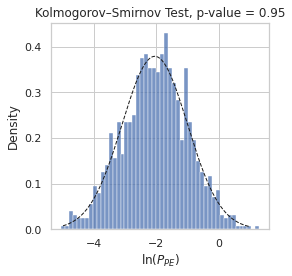

In [48]:
rcParams['figure.figsize'] = [4, 4]
# plot sampled data
sns.histplot(data = sampled, bins = 50, stat = "density")
x = np.linspace(-5, 1, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1, ls = "--")
plt.title ("Kolmogorov–Smirnov Test, p-value = " + str(pv.round(2)))
plt.xlabel("ln($P_{PE}$)")
plt.tight_layout()
#plt.savefig("fig4b_", format='svg', transparent=True)
plt.show()

In [49]:
# compare a sample of the data to the best fit normal distribution
import random

# size of the sample
s = 1000
# normal distribution parameters
mu2, std2 = norm.fit(df["ppe"])
# extract a random sample
sampled2 = random.sample(list(df["ppe"]),s)
# apply the Kolmogorov-Smirnov test
c2,pv2 = stats.kstest(stats.norm.rvs(loc = mu, scale = std, size=s), sampled2)
# p-value
pv2

0.0

In [54]:
# sample the transformed data 1000 times and compare to the transformed normal distribution
import random
p_val_ppe = []

s = 1000

for i in range(1000):
    sampled_ = random.sample(list(df["log_ppe"]),s)
    c,pv = stats.kstest(stats.norm.rvs(loc = mu, scale = std, size=s), sampled_)
    p_val_ppe.append(pv)

In [57]:
# percentage of significant p-values
len(list(filter(lambda x: x < 0.05, p_val_ppe)))/1000*100

8.3

### ROAD TYPE STRATIFICATION


In [25]:
# selected roads - colors dictionary

roads = ["motorway", "trunk", "primary", "secondary", "tertiary",  "unclassified", "residential"] 
colors = ["blue", "darkorange", "green", "red",  "gray",  "violet", "purple"]

zip_iterator = zip(roads, colors)
col_dict = dict(zip_iterator)
print(col_dict)

{'motorway': 'blue', 'trunk': 'darkorange', 'primary': 'green', 'secondary': 'red', 'tertiary': 'gray', 'unclassified': 'violet', 'residential': 'purple'}


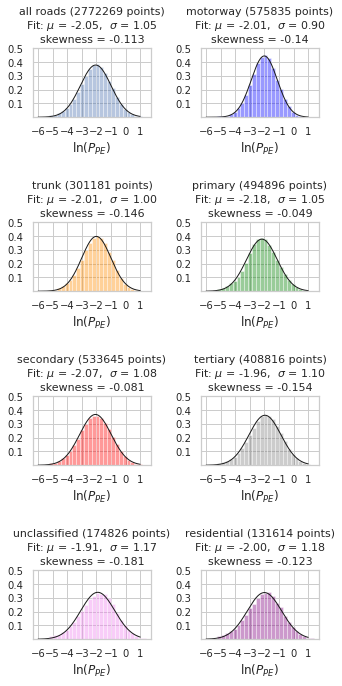

In [45]:
# plot road-specific data in the transform domain and calculate best-fit normal distribution

rcParams['figure.figsize'] = [5, 10]
from scipy.stats import norm

#f, ax_list = plt.subplots(1, 7)
fig = plt.figure()
columns = 2
rows = 4

# all points
fig.add_subplot(rows, columns, 1)
data = df["log_ppe"]
l = len(data)
# plot histo
plt.hist(data, bins=25, density=True, alpha=0.4)
# plot norm
mu, std = norm.fit(data)
# Plot the PDF.
x = np.linspace(-6, 1, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=1)
q = data.skew().round(3)
plt.title("all roads" + " (" + str(l) + " points)\n" + "Fit: $\mu$ = %.2f,  $\sigma$ = %.2f \n" % (mu, std) + "skewness = " + str(q), fontsize = 11)
plt.xticks([-6,-5,-4,-3,-2,-1,0,1], fontsize = 10)
plt.yticks([0.1,0.2,0.3,0.4,0.5], fontsize = 10)
plt.xlabel("ln($P_{PE}$)")
    
# points by road type
for index,road in enumerate(roads):
    fig.add_subplot(rows, columns, index + 2)
    # calculate observed frequency
    data = df[df["road"]==road]["log_ppe"]
    l = len(data)
    # plot histo
    plt.hist(data, bins=25, density=True, alpha=0.4, color = col_dict[road])
    # plot norm
    mu, std = norm.fit(data)
    # Plot the PDF.
    x = np.linspace(-6, 1, 1000)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=1)
    q = data.skew().round(3)
    plt.title(road + " (" + str(l) + " points)\n" + "Fit: $\mu$ = %.2f,  $\sigma$ = %.2f \n" % (mu, std) + "skewness = " + str(q), fontsize = 11)
    plt.xticks([-6,-5,-4,-3,-2,-1,0,1], fontsize = 10)
    plt.yticks([0.1,0.2,0.3,0.4,0.5], fontsize = 10)
    plt.xlabel("ln($P_{PE}$)")
    
plt.tight_layout(pad=2)
plt.savefig("fig5.svg", format='svg', transparent=True)
plt.show()